# Recurrent Neural Networks

In this lab, we will look at recurrent neural networks, and their use in natural language processing tasks. We will use RNNs both for sequence classification, and in a sequence-to-sequence model.

## Preparation

We start by importing the libraries that we will use throughout.

In [1]:
# Numpy library provides useful numeric computation utilities
import numpy as np

# We import Pyplot for its plotting utilities
import matplotlib.pyplot as plt

# We also import some randomization utilities from the random library
from random import shuffle, choice

# ... and a fancy progress bar
from tqdm import tqdm

# We import torch and torch.nn for the neural network utilities we will use
import torch
import torch.nn as nn

# We also import Pytorch data-handling utilities
import torch.utils.data as datautils

# In the previous labs, we used the torchvision module, which provided image
# processing utilities. Today we will use the torchtext module, which provides
# text processing utilities

from torchtext import data, datasets

To make our life easier further ahead, we create an auxiliary function to evaluate a network given a batch of data and a loss function. The is called `evaluate` and receives, as arguments,

* The neural network
* The input batch
* The output batch
* The loss function

The function returns both the loss and the accuracy of the network in the batch.

In [2]:
def evaluate(net, dataset, loss):
  
    # Compute dataset size
    dataset_size = len(dataset)

    # We first set the network to "evaluation mode". This is useful, for 
    # example, in dropout layers, which should behave differently in training 
    # and evaluation.
    net.eval()

    l = 0
    acc = 0

    # We compute both scores and labels
    for X, y in dataset:
        output = net(X)
        _, label = torch.max(output, dim=1)

        # Compute loss
        l += loss(output, y).item()
            
        # Compute accuracy
        acc += (label == y).double().item()

    # Average
    l = l / dataset_size
    acc = acc / dataset_size
    
    # We reset the network back to training mode
    net.train()
    
    return l, acc

We also define a general function to be used when training a neural network. We call the function `train_network`. The function shall receive, as arguments:

* The neural network
* The loss function
* The optimizer
* The training data loader

We'll also include an optional parameter to specify the number of epochs (we'll use 20 as the default value).

In [3]:
def train_network(net, loss, optimizer, dataset, num_epochs=20):
    
    # We start by initializing two lists, to track the loss and accuracy during
    # training.
    train_losses = []
    train_accuracies = []

    valid_losses = []
    valid_accuracies = []

    for ep in range(num_epochs):
        print('\n- Training epoch: %i -' % ep)

        # We use auxiliary variables to keep track of loss and accuracy within 
        # an epoch
        running_loss = 0.
        running_acc  = 0.

        for X, y in dataset:

            # We zero-out the gradient
            optimizer.zero_grad()

            # Compute output
            output = net(X)

            # Our outputs are *scores*, so we also compute the predicted labels, 
            # since we need them to check the accuracy
            #
            # To that purpose, we compute the class that maximizes the score. 
            # The max function returns both the maximum value, and the 
            # maximizing entry. We care only about the latter, so we ignore the 
            # first output. 
            #
            # Also, recall that the dimensions of the output are 
            # (batch size, n. classes). We take the maximum over the first 
            # dimension
            _, label = torch.max(output, dim=1)

            # Get loss
            l = loss(output, y)

            # Compute gradient
            l.backward()
            
            # Perform optimization step
            optimizer.step()

            # Update total running loss. We account for the number of points 
            # in the batch
            running_loss += l.item()
             
            # Update the accuracy
            running_acc += (label == y.data).double().item()

        train_losses += [running_loss / len(dataset)]
        train_accuracies += [running_acc / len(dataset)]

        # Loss and accuracy in the validation set
        aux_l, aux_a = evaluate(net, valid_set, loss)

        valid_losses += [aux_l]
        valid_accuracies += [aux_a]

        print(f'Training loss: {train_losses[-1]:.4f}')
        print(f'Training accuracy: {train_accuracies[-1]:.1%}')
        print(f'Validation loss: {valid_losses[-1]:.4f}')
        print(f'Validation accuracy: {valid_accuracies[-1]:.1%}')

    return net, train_losses, train_accuracies, valid_losses, valid_accuracies

## Preparing the dataset

The data we will be using today is available in the files `train_data.csv` and `test_data.csv` that you can find in the course's website. Download the files to your local computer and then follow the following instructions:

1. Go to the files tab in the Colab window:

<img src="https://drive.google.com/uc?id=1dRfyvq3z_kSjFhkXumKnuIpqVlFj84YA"
     alt="Image not loaded!"
     width=600 />

2. Right click anywhere on the left panel and select "Upload":

<img src="https://drive.google.com/uc?id=1McH8TMEk6Ts7ZImNlBoGr2Km1HJz3kr6"
     alt="Image not loaded!"
     width=600 />

3. Locate in your computer the files `train_data.csv` and `test_data.csv`  that you just downloaded. After it uploads, you should see them on the files panel:

<img src="https://drive.google.com/uc?id=1D5gXJl5DYZyC0ipgUJLV7lPoqmOdV4NS"
     alt="Image not loaded!"
     width=600 />

We can now use the data in this file as our dataset. The file contains a list of last names from 4 different languages (English, French, Portuguese, and Spanish), and the corresponding language, from

* English
* French
* Portuguese
* Spanish

We will also encode each name in the file as a sequence of vectors, where each vector corresponds to a letter in the name, and represents that letter using one-hot encoding. To that purpose, we define the set of all letters and run through the dataset to create our encoded sequences of letters.

In [4]:
import string

LABELS = ['English', 'French', 'Portuguese', 'Spanish']
LETTERS = list(string.ascii_letters + " .,;'-") + ['<eos>']

def input_encoding(input_str):
    ''' Receives a string as input and returns, as output, a Pytorch tensor
        containing the one-hot encoding of the provided string.'''

    one_hot_string = torch.zeros(len(input_str), 1, len(LETTERS), dtype=torch.float)
    
    for letter_idx in range(len(input_str)):
        letter = input_str[letter_idx]
        one_hot_string[letter_idx][0][LETTERS.index(letter)] = 1

    return one_hot_string

def label_encoding(output_str):
    ''' Receives a string as input and returns, as output, a Pytorch tensor
        containing the one-hot encoding of the provided label string.'''

    one_hot_label = torch.zeros(1, len(LABELS), dtype=torch.float)
    label_idx = LABELS.index(output_str)
    one_hot_label[0][label_idx] = 1

    return one_hot_label

We are now going to create a custom dataset. We create a subclass of Pytorch's `Dataset` class, and write down the `__init__`, `__len__`, and `__getitem__` methods. 

We thus load the file `names_data.csv` that we just uploaded and then use the data in it to create the dataset.

In [5]:
# To make our life easier, we use Pandas to load the csv file
import pandas as pd

# We now create our custom class
class NamesDataset(datautils.Dataset):
    def __init__(self, names_file):

        # We load the data from the csv file
        name_data = pd.read_csv(names_file)
        
        # We create a list to store the input and output pairs
        self.samples = []

        # We run through the data in the Dataframe and fill in both lists
        for idx in range(len(name_data)):
            name  = input_encoding(name_data['Name'][idx])
            label = torch.tensor([LABELS.index(name_data['Label'][idx])])

            self.samples += [(name, label)]

        shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

We can now create a dataset.

In [6]:
train_set = NamesDataset('train_data.csv')
valid_set = NamesDataset('test_data.csv')

## Creating a Recurrent Neural Network

We start by creating a very simple recurrent neural network. Recall that, in a standard feedforward network with a single hidden layer, we have

$$h = F_1(W_1 x)$$
$$y = F_o(W_o h)$$

In a recurrent network, we have that

$$h = F_1(W_{1x}x+W_{1h}h)$$
$$y = F_o(W_o h)$$

We therefore implement this architecture directly.

In [7]:
class RecurrentNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        ''' The hidden_size indicate the size of the recurrent network's 
            hidden state. '''

        # As in last week's architecture, we start by calling the constructor 
        # of the parent class
        super().__init__()

        # Dimension of the RNN's hidden state, necessary for 
        # hidden state initialization
        self.hidden_size = hidden_size

        # We now create a first layer that receives as input the 
        # network's input and the output of the hidden layer itself
        self.i2h_layer = nn.Linear(input_size + hidden_size, hidden_size)

        # We use tanh as the non-linearity
        self.tanh = nn.Tanh()

        # The second layer is the output layer. It receives the hidden state
        # as input and computes the output
        self.h2o_layer = nn.Linear(hidden_size, output_size)

        # We also create a dropout layer, just because
        self.drop_layer = nn.Dropout(dropout)

        self.hidden_init = nn.Parameter(torch.zeros(1, hidden_size))

    # We write down an auxiliary method that performs a single pass through
    # the network
    def single_pass(self, input, hidden):
        z1 = self.i2h_layer(torch.cat((self.drop_layer(input), hidden), 1))
        h1 = self.tanh(z1)
        out = self.h2o_layer(h1)

        return out, h1

    def forward(self, input):
        # Initialize the hidden state
        h = self.hidden_init

        for x in input:
            out, h = self.single_pass(x, h)

        # We need only to return the last output
        return out

## Training our neural network

We now train our neural network on our names dataset. The process is, in all aspects, similar to the one from last week's lab. We have only to define the loss and optimizer.

In [8]:
# We create a recurrent network with 128 hidden units
rnn = RecurrentNetwork(len(LETTERS), 128, len(LABELS), dropout=0.2)

# We use the cross-entropy loss
loss = nn.CrossEntropyLoss()

# ... and Adam as the optimizer
optim = torch.optim.Adam(rnn.parameters(), lr=0.001)

rnn, rnn_train_losses, rnn_train_accuracies, rnn_valid_losses, rnn_valid_accuracies = train_network(rnn, loss, optim, train_set)


- Training epoch: 0 -
Training loss: 0.5185
Training accuracy: 85.7%
Validation loss: 0.4375
Validation accuracy: 86.5%

- Training epoch: 1 -
Training loss: 0.4489
Training accuracy: 87.4%
Validation loss: 0.3735
Validation accuracy: 88.4%

- Training epoch: 2 -
Training loss: 0.4309
Training accuracy: 87.3%
Validation loss: 0.3620
Validation accuracy: 89.0%

- Training epoch: 3 -
Training loss: 0.4321
Training accuracy: 87.4%
Validation loss: 0.3737
Validation accuracy: 88.0%

- Training epoch: 4 -
Training loss: 0.4126
Training accuracy: 87.6%
Validation loss: 0.3804
Validation accuracy: 88.4%

- Training epoch: 5 -
Training loss: 0.4060
Training accuracy: 87.8%
Validation loss: 0.3744
Validation accuracy: 89.5%

- Training epoch: 6 -
Training loss: 0.4112
Training accuracy: 87.2%
Validation loss: 0.3441
Validation accuracy: 88.9%

- Training epoch: 7 -
Training loss: 0.4060
Training accuracy: 87.4%
Validation loss: 0.3499
Validation accuracy: 89.1%

- Training epoch: 8 -
Training 

We can plot loss and accuracy during training, and see how they evolved.

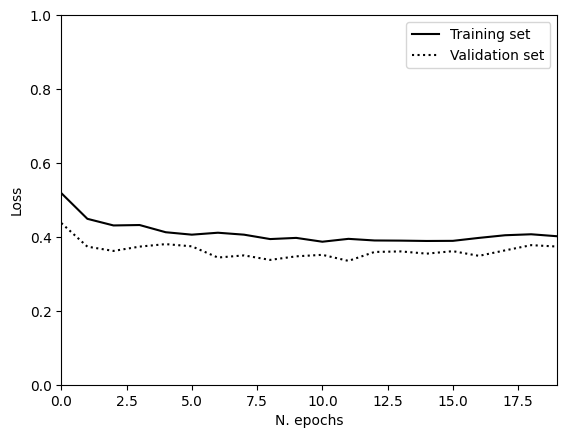

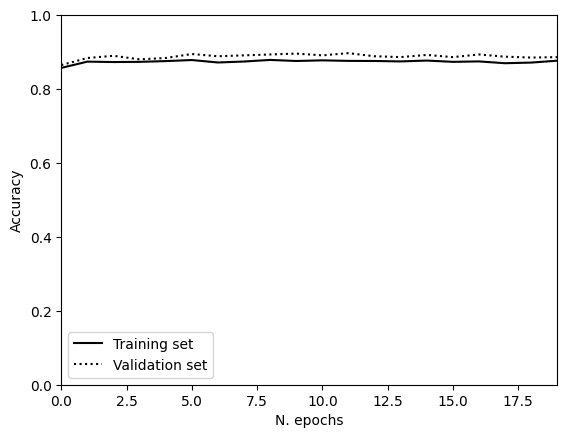

In [9]:
plt.figure()
plt.plot(rnn_train_losses, 'k-', label='Training set')
plt.plot(rnn_valid_losses, 'k:', label='Validation set')
plt.xlabel('N. epochs')
plt.ylabel('Loss')
plt.legend(loc='best')
plt.axis([0, 19, 0, 1])
plt.show()

plt.figure()
plt.plot(rnn_train_accuracies, 'k-', label='Training set')
plt.plot(rnn_valid_accuracies, 'k:', label='Validation set')
plt.xlabel('N. epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.axis([0, 19, 0, 1])
plt.show()

## Text generation using LSTM

We are now going to perform a slightly more sophisticated task on the same data we used before. In particular, we will now _generate_ names from the different countries that follow the same pattern found in the names in the dataset.

To that purpose, we need to perform a little more ground work. We slightly reformulate the `NamesDataset` class to now have as input a sequence of symbols and a category, and as output another sequence of symbols.

In [10]:
# We now create our custom class
class NamesDataset(datautils.Dataset):
    def __init__(self, names_file):

        # We load the data from the csv file
        name_data = pd.read_csv(names_file)

        # We create a list to store the input and output pairs
        self.samples = []

        # We run through the data in the Dataframe and fill in both lists
        for idx in range(len(name_data)):
            name  = name_data['Name'][idx]
            label = name_data['Label'][idx]

            self.samples += [(name, label)]

        shuffle(self.samples)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        item = self.samples[idx]

        name = item[0]
        label = item[1]
        
        # Since we're using an embedding layer, we no longer 
        # use one-hot encoding, but store only the index        
        input_tensor  = torch.tensor([[LETTERS.index(x)] for x in name], dtype=torch.long)
        label_tensor  = label_encoding(label)
        target_tensor = torch.tensor([LETTERS.index(x) for x in name[1:]] + [LETTERS.index('<eos>')], dtype=torch.long)
        
        item_dict = {"label": label,
                     "name": name,
                     "label_tensor": label_tensor,
                     "input_tensor": input_tensor,
                     "target_tensor": target_tensor}        
        
        return item_dict

We now create our dataset.

In [11]:
train_set = NamesDataset('train_data.csv')

Let's now create a LSTM-based neural network. Unlike the previous network, where we only used the last hidden state to compute the output, we now use the neural network as a sequence-to-sequence model: at each step, we use the hidden state and previous letter to "guess" the next letter.

In [12]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, n_labels, embedding_size, hidden_size, output_size, dropout=0.):
        super().__init__()
        
        # First, an embedding layer is used to convert the one-hot encoding 
        # into a feature vector
        self.i2f_layer = nn.Embedding(input_size, embedding_size)

        # We then create an LSTM layer
        self.f2h_layer = nn.LSTM(embedding_size + n_labels, hidden_size, 1)

        # Then, a linear layer that turns the LSTM hidden state into an 
        # output prediction
        self.h2o_layer = nn.Linear(hidden_size, output_size)
        
        # We include a dropout layer for the embedding
        self.dropout = nn.Dropout(dropout)

        # We add initialization parameters for the hidden state and cell
        self.hidden_init = nn.Parameter(torch.zeros(1, hidden_size))
        self.cell_init   = nn.Parameter(torch.zeros(1, hidden_size))

    def single_pass(self, letter_tensor, label_tensor, hidden, cell):
        # Compute embedding
        f = self.dropout(self.i2f_layer(letter_tensor))
        
        # Peform lstm pass
        o, (h, c) = self.f2h_layer(torch.cat((f, label_tensor), 1), (hidden, cell))
        
        # Compute output
        o = self.h2o_layer(o)

        return o, h, c

    def forward(self, input):
        name = input['input_tensor']
        label = input['label_tensor']

        h = self.hidden_init
        c = self.cell_init

        outputs = []

        for letter in name:
            out, h, c = self.single_pass(letter, label, h, c)
            outputs += [out]

        # We return all outputs
        return torch.cat(outputs)

    def sample(self, label, start_letter, max_length=20):
        ''' We will use this function to generate names given a label.'''
            
        # During sampling, we store no gradient information
        self.eval()

        with torch.no_grad():
            label_tensor = label_encoding(label)
            letter_tensor = torch.tensor([LETTERS.index(start_letter)], dtype=torch.long)
          
            h = self.hidden_init
            c = self.cell_init

            output = [start_letter]

            for i in range(max_length):
                o, h, c = self.single_pass(letter_tensor, label_tensor, h, c)
                
                _, next_idx = torch.max(o, dim=1)
                next_letter = LETTERS[next_idx]

                if next_letter == "<eos>":
                    break
                else:
                    output += [next_letter]
                    letter_tensor = torch.tensor([next_idx], dtype=torch.long)

        self.train()

        return ''.join(output)

We can now run the training routine. Note, however, that the output is now a sequence of distributions, one per symbol, so the computation of the loss must be different. For this reason, we do not use the `train_network` function defined above.

In [13]:
# We create an instance of our LSTM network.
lstm_net = LSTMNetwork(len(LETTERS), len(LABELS), 128, 256, len(LETTERS), dropout=0.3)

# Before training, let's check how well the network generates names
for i in range(10):
    label = np.random.choice(LABELS)
    letter = np.random.choice(LETTERS[:-1]).upper()
    
    print(f'Generated name in {label}:', lstm_net.sample(label, letter))

# We use the cross-entropy loss _per letter_
loss = nn.CrossEntropyLoss()

# ... and Adam as the optimizer
optim = torch.optim.Adam(lstm_net.parameters(), lr=0.001)

train_losses = []

num_epochs = 30

for ep in range(num_epochs):
    print('\n- Training epoch: %i -' % ep)

    # We use auxiliary variables to keep track of loss and accuracy within 
    # an epoch
    running_loss = 0.

    for sample in train_set:
        target = sample['target_tensor']

        # We zero-out the gradient
        optim.zero_grad()

        # We initialize the loss to 0
        l = 0

        # Compute output
        outputs = lstm_net(sample)

        # We now compute the loss for each letter in the input name, given the 
        # target.
        for i in range(len(target)):
            l += loss(outputs[i], target[i])

        # Compute gradient
        l.backward()
            
        # Perform optimization step
        optim.step()

        # Update total running loss. We account for the number of points 
        # in the batch
        running_loss += l.item()
             
    train_losses += [running_loss / len(train_set)]

    print(f'Training loss: {train_losses[-1]:.4f}')

Generated name in French: RiIgOOHOOHOOHOOHOOHOO
Generated name in French: Qjjjjjjjjjjjjjjjjjjjj
Generated name in Portuguese: JIzXLbqHLqHLsQjjjjjjj
Generated name in Spanish: VP
Generated name in Spanish: AIzXLbzXLN'wTN'wTNwsT
Generated name in English: Zo'CPjjjjjjjjjjjjjjjj
Generated name in Spanish: ,XLN'wTN'wTNwsTNwsTNw
Generated name in English: JIzXLbgWOHOOHOOHOOHOO
Generated name in Portuguese: SbCgOHOHrHOHOrHOHOrHO
Generated name in English: Zo'CPjjjjjjjjjjjjjjjj

- Training epoch: 0 -
Training loss: 14.1293

- Training epoch: 1 -
Training loss: 12.3719

- Training epoch: 2 -
Training loss: 11.5648

- Training epoch: 3 -
Training loss: 11.0100

- Training epoch: 4 -
Training loss: 10.4963

- Training epoch: 5 -
Training loss: 10.0671

- Training epoch: 6 -
Training loss: 9.6707

- Training epoch: 7 -
Training loss: 9.3129

- Training epoch: 8 -
Training loss: 9.0171

- Training epoch: 9 -
Training loss: 8.6996

- Training epoch: 10 -
Training loss: 8.4679

- Training epoch: 11 -

Now that we trained out network, let us see how well it is able to generate names given a label/language.

In [14]:
for i in range(20):
    label = np.random.choice(LABELS)
    letter = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))
    
    print(f'Generated name in {label}:', lstm_net.sample(label, letter))

Generated name in English: Kennett
Generated name in Portuguese: Romao
Generated name in Spanish: Iniguez
Generated name in French: Albert
Generated name in English: Young
Generated name in Portuguese: Faures
Generated name in French: Robert
Generated name in French: Vipond
Generated name in Portuguese: Garcia
Generated name in English: Lawlor
Generated name in French: Espard
Generated name in French: Xollins
Generated name in English: Utton
Generated name in Spanish: Quinones
Generated name in English: Duffield
Generated name in French: Kerridge
Generated name in Spanish: Gutierrez
Generated name in French: Ubina
Generated name in French: Robert
Generated name in Spanish: Iniguez


In [20]:
for label in LABELS:
    for i in range(10):
        letter = np.random.choice(list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'))
        print(f'Generated name in {label}:', lstm_net.sample(label, letter))

Generated name in English: Quirk
Generated name in English: Connolly
Generated name in English: Allington
Generated name in English: Griff
Generated name in English: Kennett
Generated name in English: Zavalas
Generated name in English: Robishaw
Generated name in English: Jefferies
Generated name in English: Holder
Generated name in English: Jefferies
Generated name in French: Ubina
Generated name in French: Vipond
Generated name in French: Espard
Generated name in French: Travere
Generated name in French: Albert
Generated name in French: Warden
Generated name in French: Dupont
Generated name in French: Norbury
Generated name in French: Travere
Generated name in French: Lefurgey
Generated name in Portuguese: Faures
Generated name in Portuguese: De santigo
Generated name in Portuguese: Romao
Generated name in Portuguese: Nesbitt
Generated name in Portuguese: Upjos
Generated name in Portuguese: Costa
Generated name in Portuguese: Maria
Generated name in Portuguese: Santiago
Generated name

In [15]:
sum(p.numel() for p in lstm_net.parameters())

422587

In [16]:
for name, param in lstm_net.named_parameters():
    print(name, param.shape)

hidden_init torch.Size([1, 256])
cell_init torch.Size([1, 256])
i2f_layer.weight torch.Size([59, 128])
f2h_layer.weight_ih_l0 torch.Size([1024, 132])
f2h_layer.weight_hh_l0 torch.Size([1024, 256])
f2h_layer.bias_ih_l0 torch.Size([1024])
f2h_layer.bias_hh_l0 torch.Size([1024])
h2o_layer.weight torch.Size([59, 256])
h2o_layer.bias torch.Size([59])


##### Activities

1. How many parameters does the first recurrent neural network have? And the LSTM network?

2. Why are exploding/vanishing gradients a more pressing issue in recurrent neural networks? And how does the LSTM architecture help to address the vanishing gradient problem?

3. Repeat the training of the LSTM network, but now using all the words in the two datasets (training and test) as training data. Let the network train for 40 epochs. Then, for each of the 4 possible labels/languages, generate 5 sample names using the trained network. Comment on the performance of the network thus trained.